This notebook provides a tutorial for:
1. training a ScribblePrompt-UNet model from scratch on a (example) dataset 
2. finetuning ScribblePrompt-UNet on a new (example) dataset
3. monitoring metrics recorded during training 

We use the [`pylot`](https://github.com/JJGO/pylot) library for experiment management.

# Setup

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import scribbleprompt

import yaml
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

# The training code makes extensive use of the pylot library  
# clone and put in your python path: https://github.com/JJGO/pylot
#TODO: make pylot pip installable
import pylot
import pylot.pandas
import pylot.analysis

# Train

## Overview
The details of a training run are specified by a yaml config file. See `../configs` for examples. 

We use tasks from the [WBC Dataset](https://github.com/zxaoyou/segmentation_WBC) for training and evaluation as an example in this tutorial. To use your own data, you should modify the list of `train_tasks` and `val_tasks` in the `data` section of your config to list your own dataloader classes.

## Command Line Training
To train a model scratch (on WBC) from the command line, run:
```
python scribbleprompt/experiment/unet.py -config train_unet.yaml 
```

To finetune ScribblePrompt-UNet (on WBC) from the command line, run:
```
python scribbleprompt/experiment/unet.py -config finetune_unet.yaml 
```

Notes:
* You will need to modify the paths in the configs before running (`CTRL-F` "#update this!")
* The experiment runner will automatically create a folder for the training run based on the start time and hash of the config file
* If the training run is interupted you can resume using `python scribbleprompt/experiment/unet.py -resume -config [PATH TO EXPERIMENT FOLDER]`
* The only difference between `train_unet.yaml` and `finetune_unet.yaml` is the `pretrained_weights` field

## Jupyter Training

Alternatively, you can train within a jupyter notebook

In [4]:
# Load the config for the training run
config = yaml.safe_load(open("../configs/train_unet.yaml", "r"))

# update the output folder path
config['log']['root'] = "./scratch"

In [5]:
from scribbleprompt.experiment.unet import ScribblePromptExperiment

# Set the GPU to use
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

# Create the experiment runner object
exp = ScribblePromptExperiment.from_config(config)

# A unique experiment folder will be created using the current time and hash of the config

Intel MKL extensions not available for NumPy

Intel MKL extensions not available for SciPy

Using slow Pillow instead of Pillow-SIMD

/autofs/cluster/dalcalab2/users/hew19/interseg/work/public_code/ScribblePrompt/notebooks/scratch/20241231_132723-9ID2-d5b928a8435737196a1fd5c5b4c5c4f6
Finished init....


In [6]:
# To train the model
# exp.run()

You can reload the experiment object later using 
```
exp = ScribblePromptExperiment(FULL_EXPERIMENT_FOLDER_PATH)
```

# Monitoring Training

This section shows how to load the metrics recorded during training

In [7]:
rs = pylot.analysis.ResultsLoader()

# Load configs for all the exeriments in the output folder
dfc = rs.load_configs('/autofs/cluster/dalcalab2/users/hew19/work/interseg-public/output/')

# Select some experiments
dfc = dfc.select(
    lr=1e-4,
    batch_size=8,
    num_workers=16,
    epochs=1000,
    superpixel_prob=0.5,
    loss_func='scribbleprompt.loss.FocalDiceLoss'
)

# Create flag for plotting
dfc['from_pretrained_weights'] = ~dfc['pretrained_weights'].isna()

dfc

  0%|          | 0/20 [00:00<?, ?it/s]

,augmentations,data,samples_per_epoch,sampling,superpixel_prob,train_tasks,val_tasks,batch_size,num_workers,pin_memory,...,prob_scribble,scribble_generators,bf16,epochs,eval_freq,grad_accumulation,prompt_iter,path,root,from_pretrained_weights
7,"[{""RandomAffine"": {""degrees"": [0, 360], ""p"": 0...",scribbleprompt.datasets.superpixel.SuperpixelM...,1000,hierarchical,0.5,"[{""_class"": ""scribbleprompt.datasets.wbc.WBC"",...","[{""_class"": ""scribbleprompt.datasets.wbc.WBC"",...",8,16,True,...,0.5,"[{""_class"": ""scribbleprompt.interactions.scrib...",True,1000,10,False,5,/autofs/cluster/dalcalab2/users/hew19/work/int...,NaN,True
13,"[{""RandomAffine"": {""degrees"": [0, 360], ""p"": 0...",scribbleprompt.datasets.superpixel.SuperpixelM...,1000,hierarchical,0.5,"[{""_class"": ""scribbleprompt.datasets.wbc.WBC"",...","[{""_class"": ""scribbleprompt.datasets.wbc.WBC"",...",8,16,True,...,0.5,"[{""_class"": ""scribbleprompt.interactions.scrib...",False,1000,10,False,5,/autofs/cluster/dalcalab2/users/hew19/work/int...,NaN,False


In [8]:
# Check the difference between the experiment configs 
# .select and .drop_constant are useful functions from pylot.pandas
dfc.drop_constant()

,pretrained_weights,bf16,path,from_pretrained_weights
7,/autofs/cluster/dalcalab2/users/hew19/work/int...,True,/autofs/cluster/dalcalab2/users/hew19/work/int...,True
13,None,False,/autofs/cluster/dalcalab2/users/hew19/work/int...,False


In [9]:
# Load the metrics for the selected experiments
df = rs.load_metrics(dfc)

  0%|          | 0/2 [00:00<?, ?it/s]

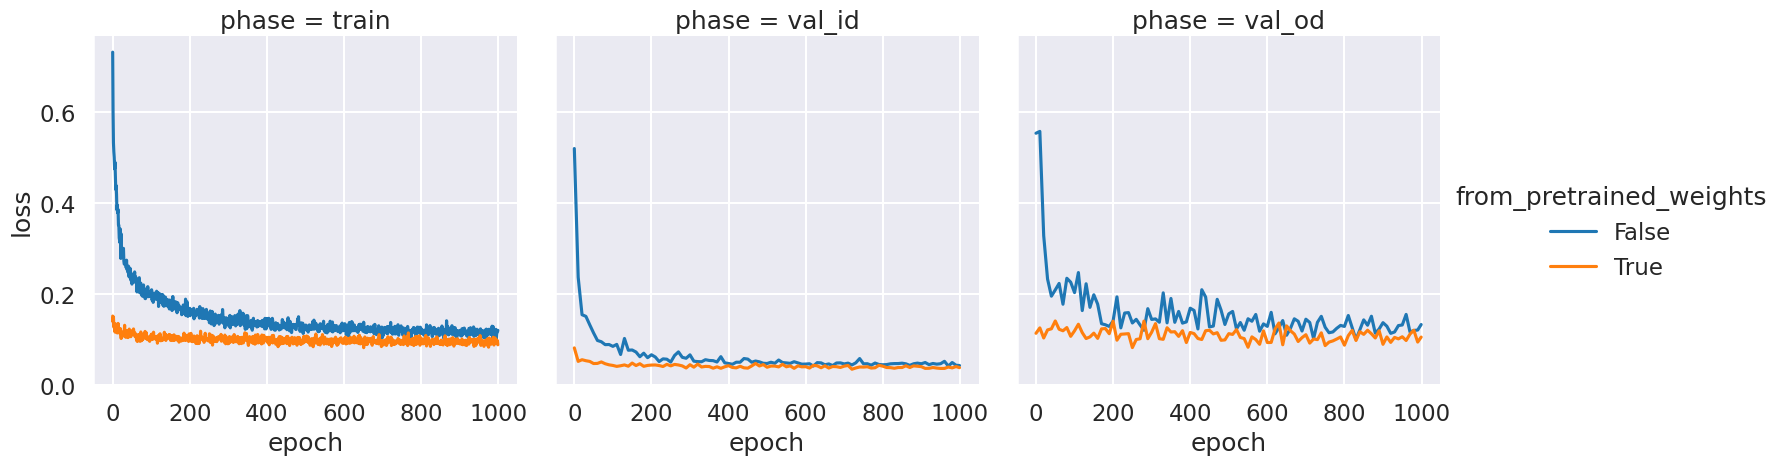

In [10]:
sns.relplot(
    data = df,
    x = 'epoch',
    y = 'loss',
    col = 'phase',
    kind='line',
    hue = 'from_pretrained_weights',
)

Note about **phases**:
* `train` = the training split of the training tasks with (data and superpixel label) augmentations
* `val_id` = the validation split of the training tasks without any augmentations
* `val_od` = the validation split of the validation tasks without any augmentations 

The training tasks and validation tasks are specified in the experiment config. **In this example**, we used the cytoplasm label for training and nucleus label for validation from the [WBC dataset](https://github.com/zxaoyou/segmentation_WBC).

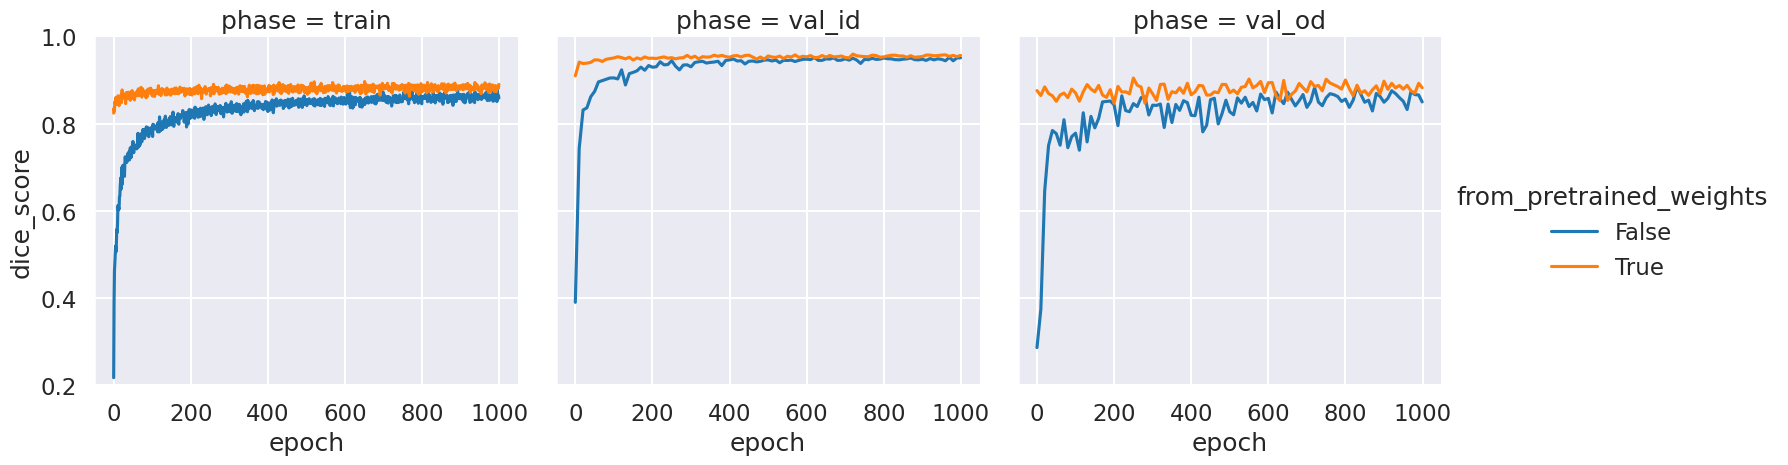

In [11]:
g = sns.relplot(
    data = df,
    x = 'epoch',
    y = 'dice_score',
    col = 'phase',
    kind='line',
    hue = 'from_pretrained_weights',
)
g.set(ylim=(0.2, 1))